### Libraries

In [79]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')


import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


# python imports
import re
import json
import os
from collections import Counter
import datetime as dt
from dateutil.parser import parse


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook
import geopandas as gpd


# twitter
# pip install twarc
from twarc import Twarc
import carmen

resolver = carmen.get_resolver()
resolver.load_locations()


# Saving models
import pickle

import config

### Reading the tweets and updating their geodata

#### Function to check if the string is datetime

In [69]:
def isDate(string, fuzzy=False):
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

In [28]:
def getLocation(t):
    fields = ['entities', 'user', 'place', 'coordinates']
    for field in fields:
        if(pd.isna(t[field]) or t[field].isnumeric() or (t[field] == 'True' or t[field] == 'False')):
            t[field] = dict()
        else:
            t[field] = eval(t[field])
    
    location = resolver.resolve_tweet(t)
    return location

In [ ]:
main_dir = './'
full_dir = main_dir + 'data_full/'
id_dir = main_dir + 'data_ids/'

df_list = []

for file in sorted(os.listdir(full_dir)):
    print('reading... ' + file)
    
    df_full = pd.read_csv(full_dir + file).drop_duplicates()
#     df_full = df_full.dropna(subset = ['id'])
    
#     df_full.to_csv(full_dir + file, index = None)
#     df_full = df_full[df_full.created_at.apply(isDate)]
    
    df_full['locations'] = df_full.apply(getLocation, axis = 1)
    df_full[['id', 'locations']].to_csv(full_dir + file[:-9] + '_loc.csv', index = None)
    df_list.append(df_full)
    
    print(file + ' ..done')
    print()
    
    
    

reading... 05-01-2020_full.csv
05-01-2020_full.csv ..done

reading... 05-02-2020_full.csv
05-02-2020_full.csv ..done

reading... 05-03-2020_full.csv
05-03-2020_full.csv ..done

reading... 05-04-2020_full.csv
05-04-2020_full.csv ..done

reading... 05-05-2020_full.csv
05-05-2020_full.csv ..done

reading... 05-06-2020_full.csv
05-06-2020_full.csv ..done

reading... 05-07-2020_full.csv


### Reading the country data

In [180]:
shapefile = 'countries.gpkg'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['NAME', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'geometry']
gdf.tail()

,country,geometry
248,Macao,"MULTIPOLYGON (((113.55860 22.16303, 113.56943 ..."
249,Ashmore and Cartier Is.,"MULTIPOLYGON (((123.59702 -12.42832, 123.59775..."
250,Bajo Nuevo Bank,"MULTIPOLYGON (((-79.98929 15.79495, -79.98782 ..."
251,Serranilla Bank,"MULTIPOLYGON (((-78.63707 15.86209, -78.64041 ..."
252,Scarborough Reef,"MULTIPOLYGON (((117.75389 15.15437, 117.75569 ..."


### Merging all the data

In [51]:
df = pd.concat(df_list)
df.tail()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,locations
155824,Fri May 15 23:59:03 +0000 2020,1261446025807462400,1261446025807462400,Fun Fact: When one person gets the #Cronavirus...,False,"[0, 132]","{'hashtags': [{'text': 'Cronavirus', 'indices'...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,NaN,NaN,False,0,0,False,False,NaN,en,None
155825,Fri May 15 23:59:33 +0000 2020,1261446149988216832,1261446149988216832,With all the small and not so small papers (al...,False,"[0, 266]","{'hashtags': [{'text': 'COVID19', 'indices': [...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,NaN,NaN,False,2,29,False,False,NaN,en,None
155826,Fri May 15 23:58:38 +0000 2020,1261445921713328128,1261445921713328128,Can’t life just go back to normal now? Ashton ...,False,"[0, 128]","{'hashtags': [{'text': 'punked', 'indices': [8...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,NaN,NaN,False,0,1,False,False,NaN,en,None
155827,Fri May 15 23:58:55 +0000 2020,1261445992060260355,1261445992060260355,#GA #COVID19 5/15 7p\n\n• Tests 301874; ⬆️16k;...,False,"[0, 272]","{'hashtags': [{'text': 'GA', 'indices': [0, 3]...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,NaN,NaN,False,4,6,False,False,False,en,"(False, Location(country='United States', stat..."
155828,Fri May 15 23:59:32 +0000 2020,1261446147169640448,1261446147169640448,Covid-19 Sniffer Dogs: The U.K.’s Latest Attem...,False,"[0, 95]","{'hashtags': [{'text': 'Coronavirus', 'indices...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.261445e+18,1.26144e+18,...,NaN,NaN,False,0,1,False,False,False,en,None


### Temporal frequency of tweets

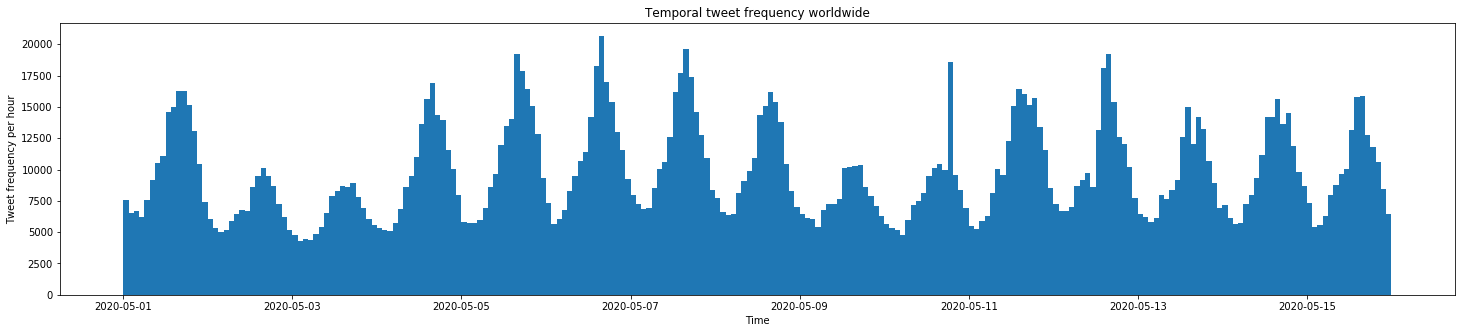

In [75]:
fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(111)
ax.set(title='Temporal tweet frequency worldwide', xlabel='Time', ylabel='Tweet frequency per hour')
plt.hist(pd.to_datetime(df.created_at), bins = 24*10)
plt.show()

### Picking out the tweet texts

In [76]:
text_en = df['text']
text_en.tail()

KeyError: 'text'

### Removing URLs from tweets

In [ ]:
text_en_lr = text_en.apply(lambda x: re.sub(r"https\S+", "", str(x)))
text_en_lr.head()

### Converting all tweets to lowercase

In [ ]:
text_en_lr_lc = text_en_lr.apply(lambda x: x.lower())
text_en_lr_lc.head()

### Removing punctuations

In [ ]:
text_en_lr_lc_pr = text_en_lr_lc.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
text_en_lr_lc_pr.head()

### Removing stopwords

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.update(['#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19'])

text_en_lr_lc_pr_sr = text_en_lr_lc_pr.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
text_en_lr_lc_pr_sr.head()

### Concatenating all the tweets into a list of words

In [ ]:
word_list = [word for line in text_en_lr_lc_pr_sr for word in line.split()]
word_list[:5]

### Calculating the Term Frequency

In [ ]:
sns.set(style="darkgrid")
counts = Counter(word_list).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df
counts_df.columns = ['word', 'frequency']

fig, ax = plt.subplots(figsize = (12, 12))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)
plt.savefig('wordcount_bar.png')

In [ ]:
wordcloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(word_list))


plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('wordcloud.png')



## Sentiment Analysis

### Getting the polarity scores for each tweet

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = text_en_lr_lc_pr_sr.apply(lambda x: sid.polarity_scores(x))
sent_scores_df = pd.DataFrame(list(sentiment_scores))
sent_scores_df.tail()

### Classifying the scores based on the compount polarity value

In [ ]:
sent_scores_df['val'] = sent_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
sent_scores_df.head()

### Plotting the sentiment score counts

In [ ]:
sent_counts = pd.DataFrame.from_dict(Counter(sent_scores_df['val']), orient = 'index').reset_index()
sent_counts.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_counts)
plt.savefig('sentiment.png')

### Temporal plot of the sentiments

In [ ]:
sentiments_time_df = pd.DataFrame()
sentiments_time_df['time'] = df['created_at']
sentiments_time_df['polarity'] = sent_scores_df['compound']
sentiments_time_df.index = pd.to_datetime(sentiments_time_df['time'])


ot = sentiments_time_df.sample(frac=.001)
ot['time'] = pd.to_datetime(ot['time'])
ot.index = pd.to_datetime(ot['time'])
ot.sort_index(inplace=True)
ot['expanding'] = ot['polarity'].expanding().mean()
ot['rolling'] = ot['polarity'].rolling('1h').mean()

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.scatter(ot['time'],ot['polarity'], label='Tweet Sentiment', s = 10, color = 'y')
ax.plot(ot['time'],ot['rolling'], color ='r', label='Rolling Mean', linewidth = 5)
ax.plot(ot['time'],ot['expanding'], color='b', label='Expanding Mean', linewidth = 5)
ax.set_xlim([dt.date(2020,5,1),dt.date(2020,5,9)])
ax.set(title='Tweet Sentiments over Time', xlabel='Date', ylabel='Sentiment polarity')
ax.legend(loc='best')
fig.tight_layout()
plt.savefig('temporal_sentiments.png')


### Sentiment scores distribution

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set(title='Tweet Sentiments distribution', xlabel='polarity', ylabel='frequency')
sns.distplot(sentiments_time_df['polarity'], bins=30, ax=ax)
# plt.show()
plt.savefig('sentiment_distribution.png')

### Word cloud of polar words

In [ ]:
polar_tweets_df = pd.DataFrame()
polar_tweets_df['tweet'] = text_en_lr_lc_pr_sr
polar_tweets_df['polarity'] = sent_scores_df['val']

positive = polar_tweets_df[polar_tweets_df['polarity'] == 'positive']['tweet']
negative = polar_tweets_df[polar_tweets_df['polarity'] == 'negative']['tweet']
neutral = polar_tweets_df[polar_tweets_df['polarity'] == 'neutral']['tweet']

positive_list = [word for line in positive for word in line.split()]
negative_list = [word for line in negative for word in line.split()]
neutral_list = [word for line in neutral for word in line.split()]

positive_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(positive_list))

negative_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(negative_list))

neutral_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral_list))


fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(positive_cloud)
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')
# axs[0, 0].tight_layout(pad = 1)

axs[0, 1].imshow(negative_cloud)
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')
# axs[0, 1].tight_layout(pad = 1)

axs[1, 0].imshow(neutral_cloud)
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')
# axs[1, 0].tight_layout(pad = 1)

axs[1, 1].imshow(wordcloud)
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')
# axs[1, 0].tight_layout(pad = 1)
plt.savefig('joint_cloud.png')



In [90]:
df.iloc[0].locations[1]

Location(country='United States', state='California', known=True, id=440)

In [91]:
import geopandas
import geoplot

world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
boroughs = geopandas.read_file(
    geoplot.datasets.get_path('nyc_boroughs')
)
collisions = geopandas.read_file(
    geoplot.datasets.get_path('nyc_injurious_collisions')
)

In [99]:
def getCountry(loc):
    if(loc):
        return loc[1].country
    return None

In [106]:
locs = df.locations.apply(getCountry).dropna()

In [183]:
country_df = pd.DataFrame.from_dict(Counter(locs), columns = ['count'], orient = 'index').reset_index()
country_df.columns = ['country', 'count']

In [184]:
len(country_df)

185

In [227]:
country_df.loc[country_df.country == 'United States', 'country'] = 'United States of America'
country_df.loc[country_df.country == 'Vatican City', 'country'] = 'Vatican'
country_df.loc[country_df.country == 'Antigua and Barbuda', 'country'] = 'Antigua and Barb.'
country_df.loc[country_df.country == 'Bosnia and Herzegovina', 'country'] = 'Bosnia and Herz.'
country_df.loc[country_df.country == 'Czech Republic', 'country'] = 'Czechia'
country_df.loc[country_df.country == 'The Bahamas', 'country'] = 'Bahamas'
country_df.loc[country_df.country == 'The Netherlands', 'country'] = 'Netherlands'

country_df.to_csv('./data_full/locations/country_frequency.csv', index = None)

In [214]:
country_df.head()

,country,count
0,United States of America,600768
1,Nigeria,36756
2,India,167464
3,United Kingdom,189965
4,Saudi Arabia,2418


In [215]:
country_freq_df = pd.merge(gdf, country_df, on='country')
print(country_freq_df.shape)
country_freq_df.sort_values(['count'], ascending = False).head()

(160, 3)


,country,geometry,count
123,United States of America,"MULTIPOLYGON (((-95.16057 49.36949, -95.10282 ...",600768
67,United Kingdom,"MULTIPOLYGON (((-7.24710 55.06932, -7.25674 55...",189965
7,India,"MULTIPOLYGON (((77.80035 35.49541, 77.81533 35...",167464
124,Canada,"MULTIPOLYGON (((-99.79271 67.80492, -99.79528 ...",79663
83,Nigeria,"MULTIPOLYGON (((3.59640 11.69577, 3.64777 11.7...",36756


In [216]:
country_df[country_df.country.isin(np.setdiff1d(country_df['country'], country_freq_df['country']))]

,country,count
41,Antarctica,152
72,Federated States of Micronesia,63
76,Swaziland,77
101,Netherlands Antilles,7
105,Ivory Coast,71
120,Macau-China,59
122,Democratic Republic of Congo,84
133,Christmas Island,30
137,Cape Verde,9
143,Cayman Islands,162


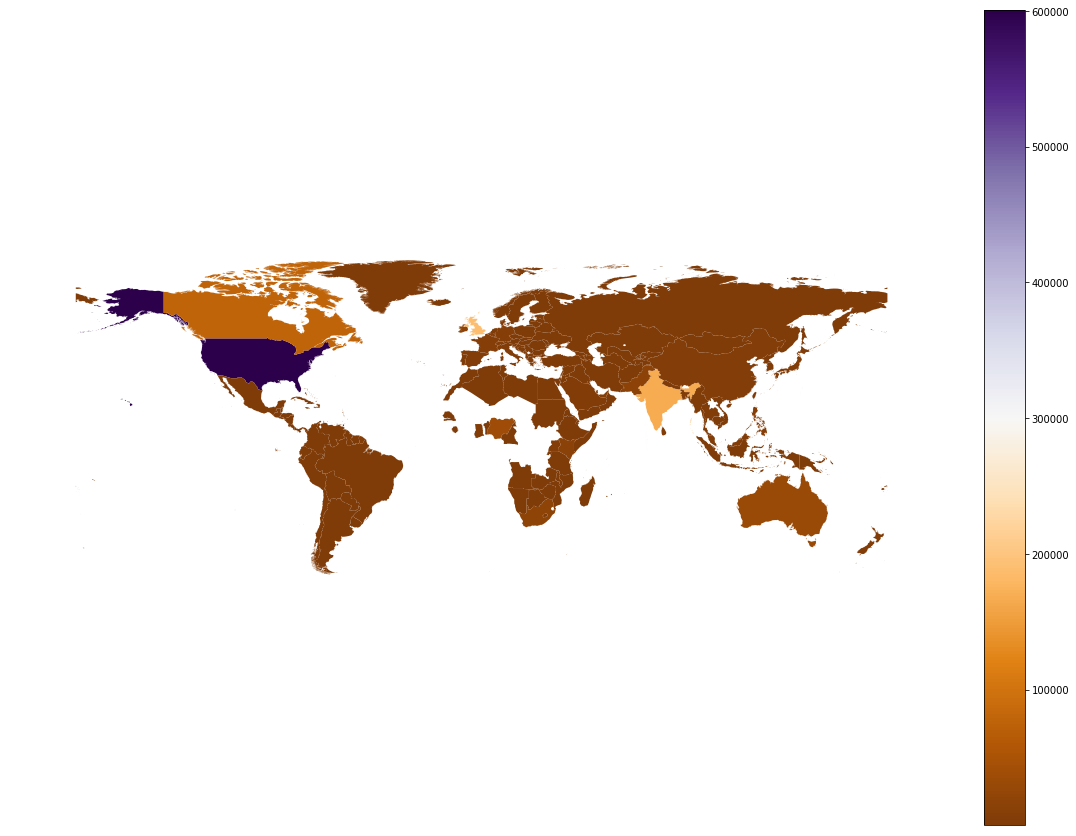

In [226]:
figZ, ax = plt.subplots(1, figsize=(20,15))
ax.axis('off')
country_freq_df.plot(ax=ax, column='count', legend=True, cmap = 'PuOr')

In [212]:
gdf[gdf['country'].str.match('.*Nethe.*')]

,country,geometry
94,Netherlands,"MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2..."


In [171]:
world[world['name'].str.match('^S.*')].shape

(19, 6)